<a href="https://colab.research.google.com/github/valy3124/SupervisedLearning/blob/main/IS_Laborator_2_Procesarea_imaginilor_medicale_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setul de date - Chest X-Ray Images (Pneumonia)

Pneumonia este o afecțiune inflamatorie a plămânilor care afectează alveolele. Simptomele includ de obicei o combinație de tuse productivă sau uscată, dureri în piept, febră și dificultăți de respirație. Severitatea afecțiunii este variabilă.

Pneumonia este de obicei cauzată de infecția cu viruși sau bacterii și mai rar de alte microorganisme, anumite medicamente sau afecțiuni precum bolile autoimune. Factorii de risc includ fibroza chistică, boala pulmonară obstructivă cronică (BPOC), siclemie, astmul, diabetul, insuficiența cardiacă, antecedentele de fumat, o capacitate slabă de a tuse (cum ar fi în urma unui accident vascular cerebral) și un sistem imunitar slab. Diagnosticul se bazează adesea pe simptome și pe examenul fizic. Radiografiile toracice, testele de sânge și cultura sputei pot ajuta la confirmarea diagnosticului.

https://ro.wikipedia.org/wiki/Pneumonie

<center>
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.health.harvard.edu%2Fmedia%2Fcontent%2Fimages%2Fmedical-illustrations%2Fpneumonia-GettyImages-1010467510.jpg&f=1&nofb=1" width="600"/> </center>

# Setul de date - Chest X-Ray Images (Pneumonia)

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

Setul de date actual conține 624 imagini cu raze X (în format JPEG) și 2 categorii: Normal si Pneumonie. Acesta este doar o bucată mică din setul de date inițial care conține 5863 imagini cu raze X.

Imaginile cu raze X toracice (anterior-posterior) au fost selectate din cohorte retrospective de pacienți pediatrici cu vârsta cuprinsă între unu și cinci ani de la Centrul Medical pentru Femei și Copii din Guangzhou, Guangzhou. Toate imaginile cu raze X toracice au fost efectuate ca parte a îngrijirii clinice de rutină a pacienților.

Pentru analiza imaginilor cu raze X toracice, toate radiografiile toracice au fost inițial verificate pentru controlul calității prin eliminarea tuturor scanărilor de calitate scăzută sau care nu pot fi citite. Diagnosticele pentru imagini au fost apoi evaluate de doi medici experți înainte de a fi autorizate pentru instruirea sistemului AI. Pentru a ține seama de eventualele erori de notare, setul de evaluare a fost verificat și de un al treilea expert.


<img src="https://www.researchgate.net/publication/362659358/figure/fig1/AS:11431281085465926@1663777752282/Comparison-between-normal-and-viral-and-bacterial-pneumonia-alveoli-after-x-ray-detection.jpg" width="900"/>

Radiografia toracică normală (stânga) prezintă plămâni curați, fără zone de opacificare anormală în imagine. Pneumonia bacteriană (mijloc) prezintă de obicei o consolidare focală lobară, în acest caz în lobul superior drept (săgeți albe), în timp ce pneumonia virală (dreapta) se manifestă cu un model „interstițial” mai difuz în ambii plămâni.

# Importare biblioteci

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os
import glob
from tqdm.notebook import tqdm

import albumentations as A

# Încărcare set de date

In [51]:
!unzip dataset.zip

Archive:  dataset.zip
replace dataset/NORMAL/IM-0001-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [76]:
data = glob.glob('./dataset/**/*.jpeg')

print(f"Dataset-ul are {len(data)} imagini.")

Dataset-ul are 624 imagini.


# Distribuția claselor

In [77]:
DIR = "./dataset/"
norm = glob.glob(os.path.join(DIR, "NORMAL/*.jpeg"))
pneu = glob.glob(os.path.join(DIR, "PNEUMONIA/*.jpeg"))

print(f"Numărul de imagini cu pneumonie este {len(norm)}")
print(f"Numărul de imagini normale este  {len(pneu)}")

Numărul de imagini cu pneumonie este 234
Numărul de imagini normale este  390


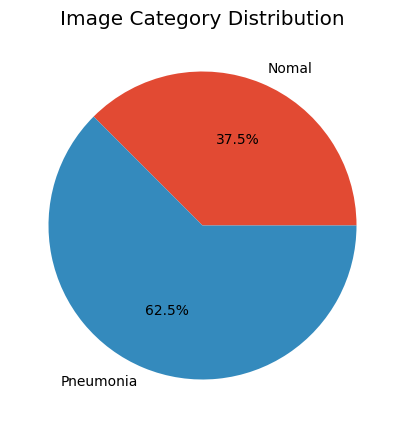

In [54]:
labels = ['Nomal', 'Pneumonia']
targets = [len(norm), len(pneu)]

plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

# EDA

In [55]:
random.shuffle(norm)
random.shuffle(pneu)
images = norm[:50] + pneu[:50]

random.shuffle(images)

cv2_images = [cv2.resize(cv2.imread(img), (256, 256)) for img in images]

# Afișarea imaginilor inițiale

In [56]:
def plot_images(n_col, n_rows, images):
  fig=plt.figure(figsize=(12, 6))
  columns = n_col; rows = n_rows

  for i in range(1, columns*rows +1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(images[i - 1])
      plt.axis(False)

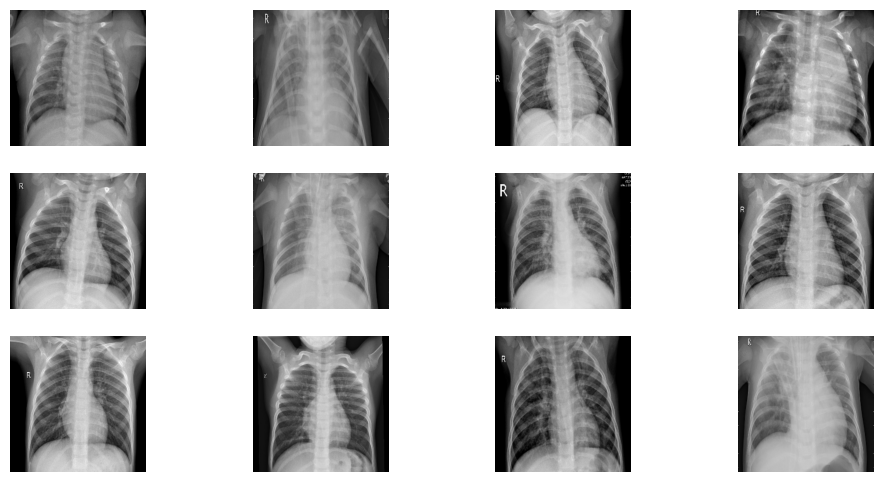

In [57]:
plot_images(4, 3, cv2_images)

# Metoda Ben Graham

Metoda Ben Graham implică utilizarea imaginilor în HSV și apoi aplicarea de estompare Gaussiană.

In [58]:
def ben_graham(image):
  img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)

  return img

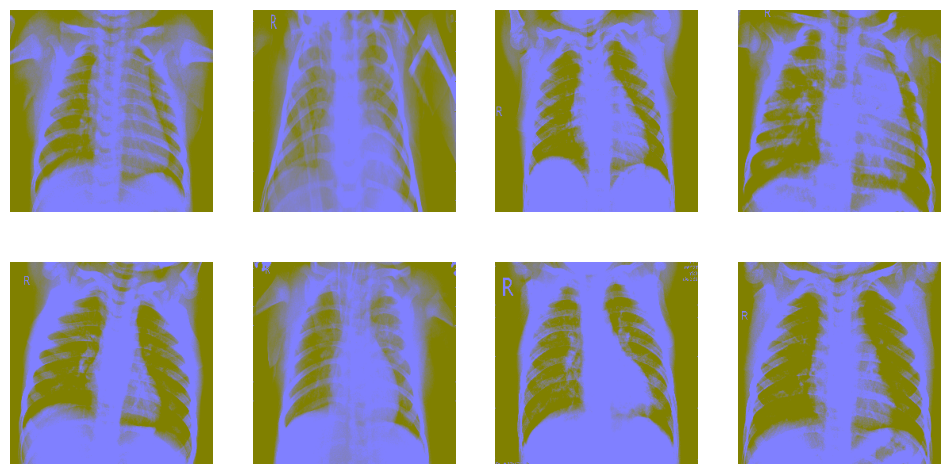

In [59]:
ben_graham_images = list(map(ben_graham, cv2_images[:10]))
plot_images(4, 2, ben_graham_images)

# Scăderea fundalului

Scăderea fundalului este o tehnică utilizată pentru a separa obiectele de interes de fundalul unei scene. Procesul implică compararea fiecărui cadru dintr-o secvență video sau imagine statică cu un model de fundal, care poate fi construit pe baza imaginilor anterioare.

Scăderea fundalului încearcă să identifice părțile din imagine care rămân constante (considerate fundal) și să evidențieze regiunile care diferă (obiecte în mișcare sau elemente de interes).

https://medium.com/@muhammadsabih56/background-subtraction-in-computer-vision-402ddc79cb1b

In [60]:
fgbg = cv2.createBackgroundSubtractorMOG2()

def background_subtract(image):
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  img = fgbg.apply(img)

  return img

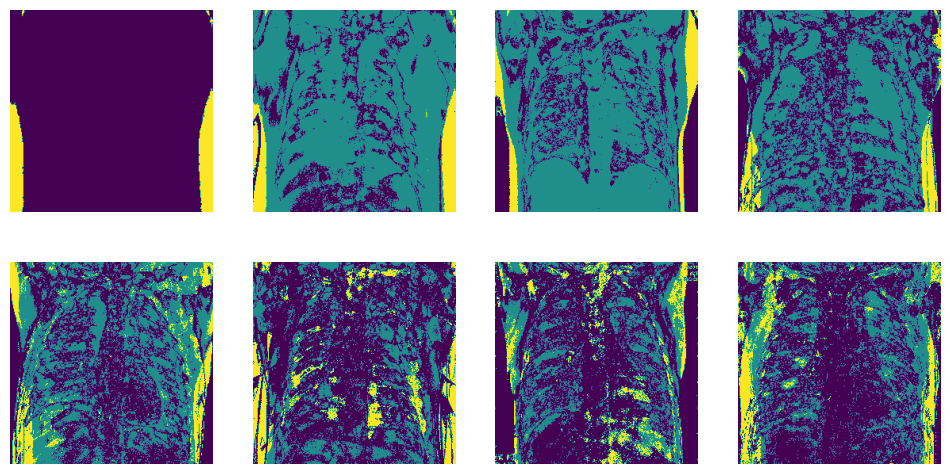

In [61]:
background_subtract_images = list(map(background_subtract, cv2_images[:10]))
plot_images(4, 2, background_subtract_images)

# Erodarea imaginilor

Erodarea imaginilor este o tehnică de procesare a imaginilor care face parte din domeniul morfologiei matematice și este utilizată pentru a reduce detaliile sau zgomotul dintr-o imagine. Procedeul constă în "subțierea" obiectelor din imagine prin eliminarea pixelilor de pe marginea acestora.

În erodare, un element structural (de obicei o matrice de pixeli) este suprapus pe imagine, iar pixelul central este setat la valoarea minimă din vecinătatea definită de elementul structural. Aceasta are ca efect micșorarea contururilor obiectelor și eliminarea zgomotului.

https://medium.com/@anshul16/erosion-morphological-operation-image-processing-18537f7c66cd

In [62]:
def erosion(image):
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  kernel = np.ones((5, 5), np.uint8)
  img_erosion = cv2.erode(img, kernel, iterations=3)

  return img_erosion

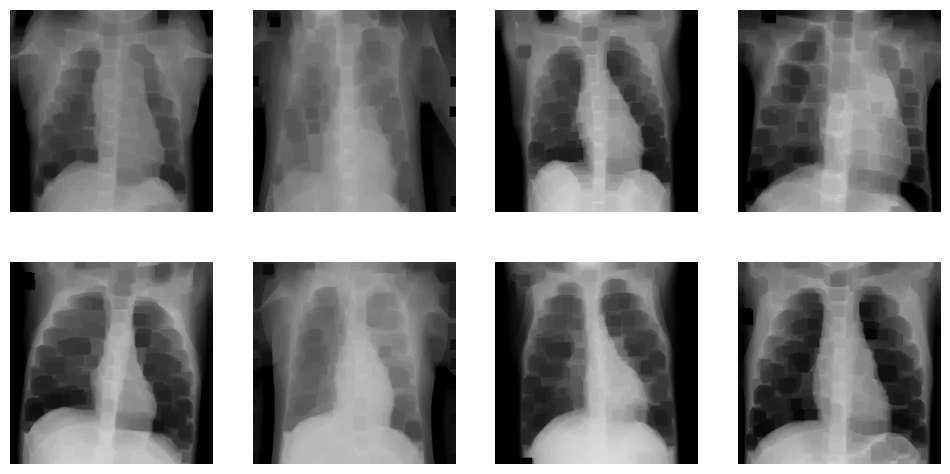

In [63]:
erosion_images = list(map(erosion, cv2_images[:10]))
plot_images(4, 2, erosion_images)

# Dilatarea imaginilor

Dilatarea imaginilor este o tehnică utilizată în procesarea imaginilor pentru a extinde regiunile luminoase dintr-o imagine. Aceasta funcționează prin adăugarea de pixeli la marginile obiectelor din imagine. În dilatare, pixelul central dintr-o regiune este setat la valoarea maximă din vecinătatea sa. Astfel, obiectele devin mai mari, umplând eventualele goluri sau legând părți separate ale unui obiect. Dilatarea este utilizată pentru a accentua caracteristicile esențiale, a reconstrui obiectele fragmentate sau a elimina golurile dintre obiecte adiacente.

https://medium.com/@anshul16/dilation-morphological-operation-image-processing-82d16a619f59

In [64]:
def dilatation(image):
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  kernel = np.ones((5, 5), np.uint8)
  img_dilatation = cv2.dilate(img, kernel, iterations=3)

  return img_dilatation

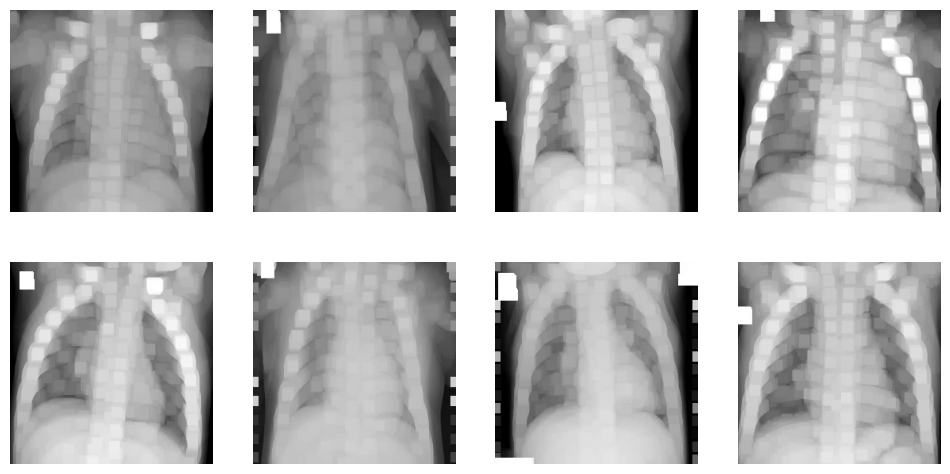

In [65]:
dilatation_images = list(map(dilatation, cv2_images[:10]))
plot_images(4, 2, dilatation_images)

# Detectarea conturului cu Canny


Detectorul Canny este un algoritm popular de detectare a marginilor în procesarea imaginilor, utilizat pentru a evidenția contururile obiectelor într-o imagine.

Algoritmul funcționează în mai multe etape: mai întâi, imaginea este filtrată cu un filtru Gaussian pentru a netezi zgomotul, apoi se calculează gradientul imaginii pentru a detecta modificările abrupte de intensitate, adică marginile. Urmează aplicarea unei tehnici de non-maximal suppression pentru a subția marginile și a elimina răspunsurile false. În final, se aplică histerezis folosind două praguri pentru a conecta marginile detectate într-un mod continuu.

https://medium.com/perspectivesondatascience/preprocessing-with-computer-vision-part-v-edge-detection-1b51e37d5d3f

In [66]:
def canny(image):
  img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  edges = cv2.Canny(img, 80, 100)

  return edges

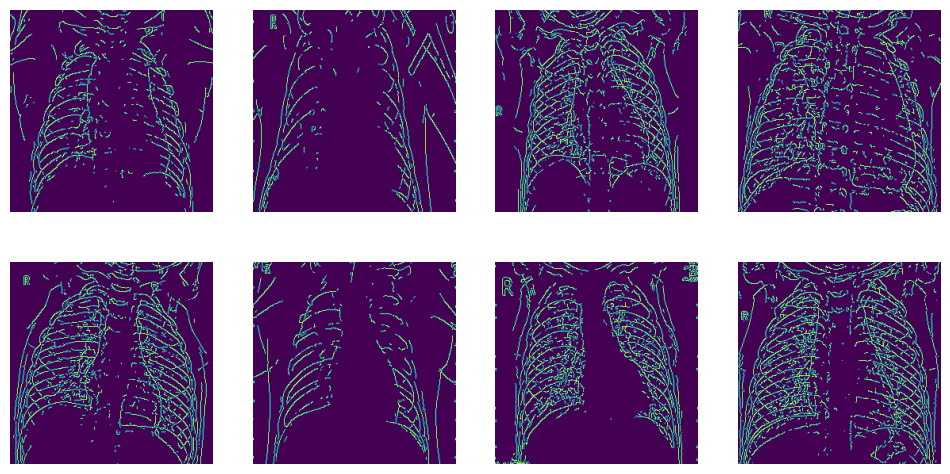

In [67]:
canny_images = list(map(canny, cv2_images[:10]))
plot_images(4, 2, canny_images)

# Augmentari cu Albumentations

Albumentations este o bibliotecă puternică și flexibilă pentru augmentarea imaginilor, utilizată frecvent în sarcini de procesare și învățare automată.

Aceasta oferă o gamă largă de transformări eficiente care pot fi aplicate imaginilor pentru a îmbunătăți performanța și generalizarea modelelor, reducând supraînvățarea (overfitting). Printre operațiile suportate se numără rotația, scalarea, flip-ul, modificarea contrastului și a luminozității, distorsiuni geometrice, și multe altele.

https://albumentations.ai/docs/

In [68]:
def plot_multiple_img(img_matrix_list, title_list, nrows, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(12, 6), nrows=nrows, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 20)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=12)
    plt.show()

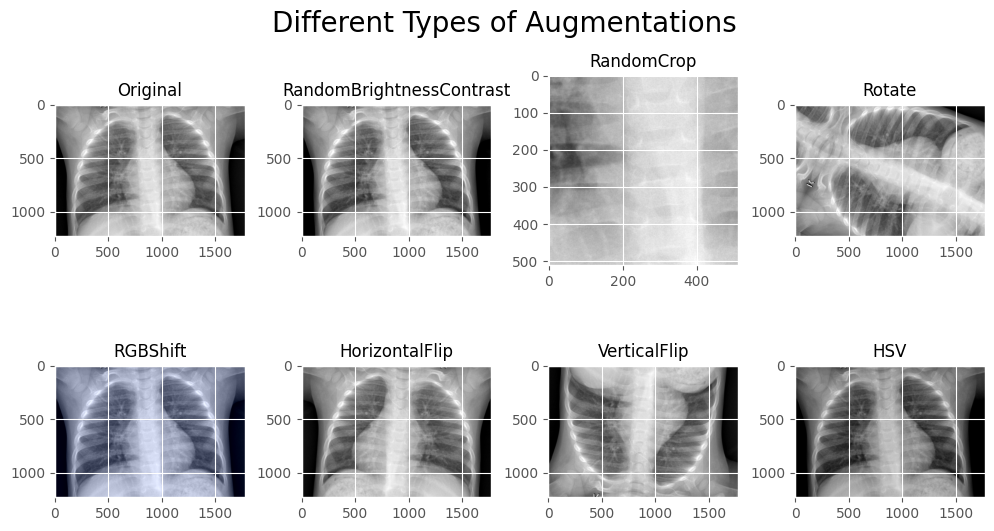

In [69]:
chosen_image = cv2.imread(images[25])
albumentation_list = [A.RandomBrightnessContrast(p=1),
                      A.RandomCrop(p=1,height = 512, width = 512), A.Rotate(p=1, limit=90),
                      A.RGBShift(p=1),
                      A.HorizontalFlip(p=1), A.VerticalFlip(p=1),
                      A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)

titles_list = ["Original", "RandomBrightnessContrast",
               "RandomCrop","Rotate", "RGBShift","HorizontalFlip", "VerticalFlip", "HSV"]

plot_multiple_img(img_matrix_list, titles_list, nrows = 2, ncols = 4,main_title="Different Types of Augmentations")

# Normalizarea imaginilor

Normalizarea imaginilor este un proces important în prelucrarea imaginilor, care ajută la ajustarea valorilor pixelilor astfel încât acestea să aibă o distribuție mai uniformă. Acest proces poate îmbunătăți performanța algoritmilor de învățare automată și a tehnicilor de procesare a imaginilor. În acest laborator, vom discuta două metode comune de normalizare:
*   normalizarea Min-Max
*   normalizarea Z-score



### Normalizarea Min-Max

Normalizarea Min-Max ajustează valorile pixelilor pentru a le scala într-un interval specificat, de obicei între 0 și 1. Acest lucru se face pentru fiecare pixel al imaginii, utilizând formula:

$$I'(x, y) = \frac{I(x, y) - \text{min}(I)}{\text{max}(I) - \text{min}(I)}$$

unde:

* $I(x, y)$ este valoarea pixelului original la coordonatele \( (x, y) \),
* $ \text{min}(I) $ este valoarea minimă a pixelilor din întreaga imagine,
* $ \text{max}(I) $ este valoarea maximă a pixelilor din întreaga imagine,
* $ I'(x, y) $ este valoarea pixelului normalizat la coordonatele \( (x, y) \).

**Beneficii**

Această metodă asigură că toate valorile pixelilor se încadrează într-un interval comun, facilitând procesarea ulterioară.

### Normalizarea Z-score

Normalizarea Z-score transformă valorile pixelilor astfel încât acestea să aibă o medie de 0 și o deviație standard de 1. Acest proces se efectuează pentru fiecare pixel al imaginii, utilizând formula:

$$I'(x, y) = \frac{I(x, y) - \mu}{\sigma}$$

unde:


* $ I(x, y) $ este valoarea pixelului original la coordonatele \( (x, y) \),
* $ \mu $ este media valorilor pixelilor din întreaga imagine,
* $ \sigma $ este deviația standard a valorilor pixelilor din întreaga imagine,
* $ I'(x, y) $ este valoarea pixelului normalizat la coordonatele \( (x, y) \).


**Beneficii**

Această metodă este utilă pentru a elimina influența valorilor extreme și pentru a face distribuția pixelilor mai uniformă.


# Exerciții propuse



1.   Aplicați filtrul CLAHE din Albumentations pentru 5 imagini din setul de date. Pentru fiecare imagine dorim să vizualizăm varianta originală și cea rezultată după aplicarea filtrului CLAHE.




In [70]:
def clahe(image):
  #Apply  clahe filter to image

  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  clahe_filter = A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0)
  enhanced_image = clahe_filter(image=img)['image']
  return enhanced_image

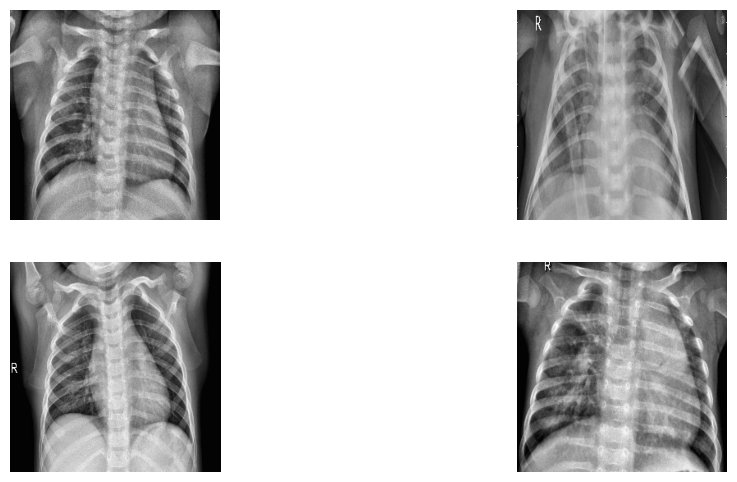

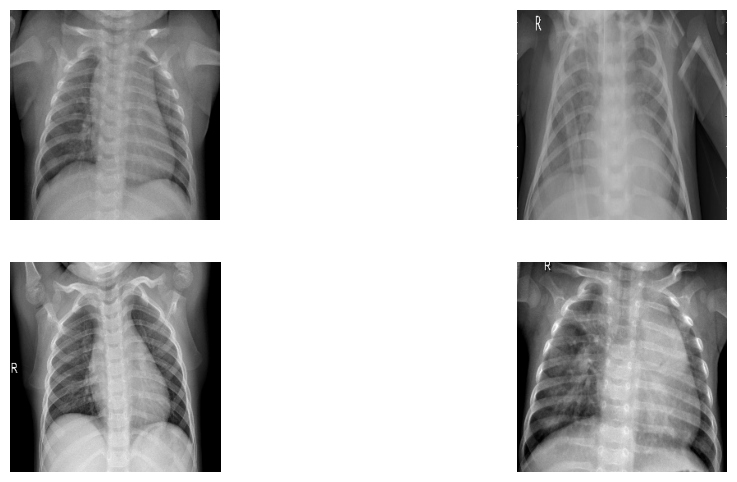

In [71]:
clahe_images = list(map(clahe, cv2_images[:5]))
plot_images(2, 2, clahe_images)

plot_images(2, 2, cv2_images)


2.   Alegeți o imagine din setul de date și pentru aceasta implementați o modalitate prin care putem vizualiza histograma acestei imagini. Apoi aplicați filtrul CLAHE (ca la exercițiul anterior) după care afișați histograma pentru imaginea obținută. Ce diferențe apar între cele două?



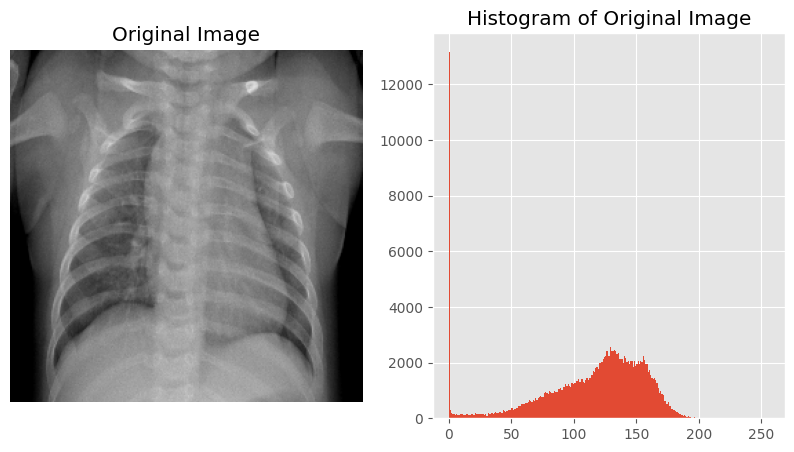

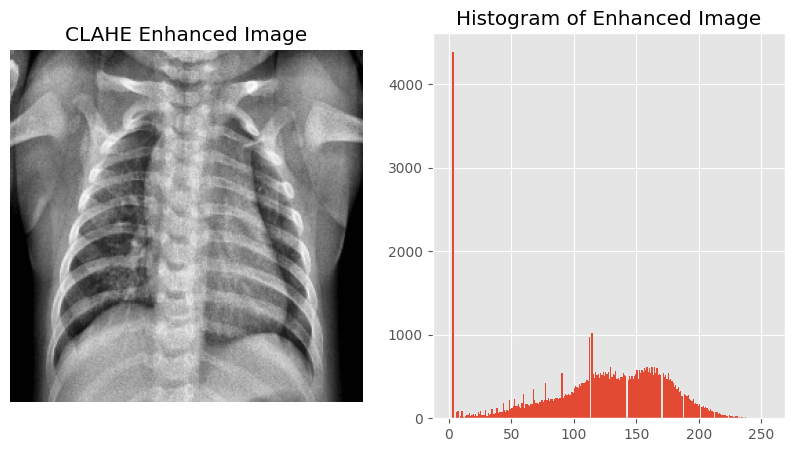

In [96]:
# TODO

#Select a random image
img = cv2_images[0]


#Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

#Plot the histogram of the original image
plt.subplot(1, 2, 2)
plt.hist(img.ravel(), 256, [0, 256])
plt.title('Histogram of Original Image')

plt.show()


clahe_img = clahe(img)
clahe_img_gray = cv2.cvtColor(clahe_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(clahe_img_gray, cmap='gray')
plt.title('CLAHE Enhanced Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.hist(clahe_img_gray.ravel(), 256, [0, 256])
plt.title('Histogram of Enhanced Image')

plt.show()


3.   Aplicați o transformare de decupare (Crop) pentru imaginea `image` pentru a extrage o regiune de interes (ROI) din imagine. Pentru acest lucru, veți furniza coordonatele care vă sunt furnizate (`x`, `y`, `height`, `width`).
Afișați atât imaginea originală, cât și imaginea rezultată după decupare.

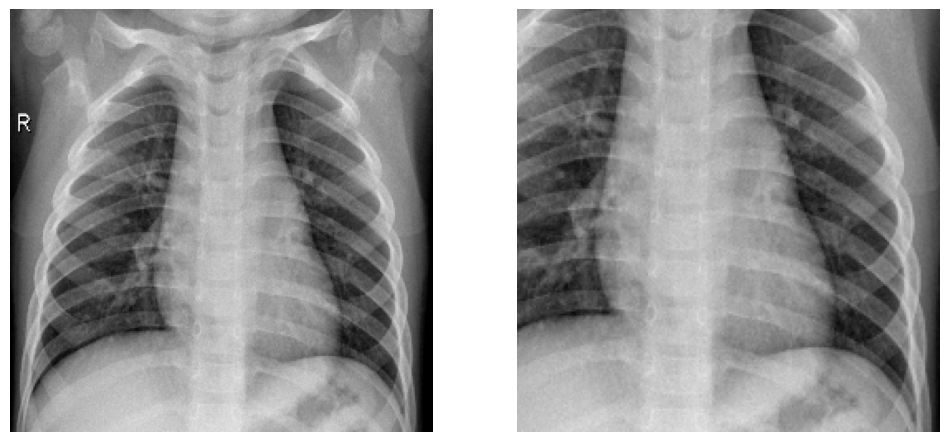

In [73]:
# TODO

img = cv2_images[7]

#ROI
x, y, width, height = 50, 50, 200, 200

crop = A.Crop(x_min=x, y_min=y, x_max=x+width, y_max=y+height)

cropped_image = crop(image=img)

imagesPlot = [cv2_images[7], cropped_image['image']]

plot_images(2, 1, imagesPlot)

4. Alegeți o imagine din setul de date și scrieți o functie pentru a normaliza acea imagine. După care afișați histograma pentru imaginea inițiala și imaginea obținută. Ce diferențe apar între cele două?

In [81]:
# TODO
def normalize_image(image, dataset):


  # Normalize the pixel values using Max-Min strategy
  min_img = np.min(dataset)
  max_img = np.max(dataset)
  normalized_image = (image - min_img) / (max_img - min_img)

  return normalized_image

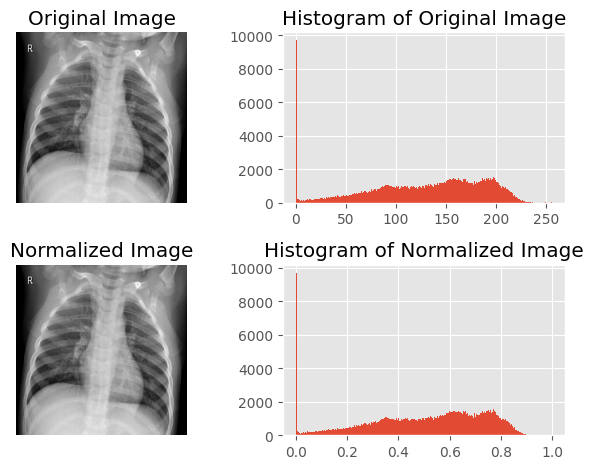

In [82]:
img = cv2_images[4]

normalized_img = normalize_image(img, cv2_images)


plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.hist(img.ravel(), 256, [0, 256])
plt.title('Histogram of Original Image')

plt.subplot(2, 2, 3)
plt.imshow(normalized_img, cmap='gray')
plt.title('Normalized Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.hist(normalized_img.ravel(), 256, [0, 1])
plt.title('Histogram of Normalized Image')

plt.tight_layout()
plt.show()



5. Implementați un pipeline de preprocesare a unei imagini de raze X, pentru a evidenția scheletul. Pentru acest lucru, trebuie să realizați următorii pași:

*   **Pasul 1 - Convertirea în grayscale:** Imaginile de raze X sunt de obicei procesate în tonuri de gri pentru a reduce dimensiunea datelor și a pune în evidență structura relevantă.
*   **Pasul 2 - Îmbunătățirea contrastului:** Pentru a scoate în evidență detalii fine, aplicați Contrast Limited Adaptive Histogram Equalization (CLAHE). Acest pas ajută la obținerea unui contrast mai bun pentru structurile osoase.
*   **Pasul 3 - Detectarea marginilor:** Folosiți filtrul Sobel pentru a detecta marginile orizontale și verticale. Această metodă evidențiază tranzițiile bruște de intensitate, cum ar fi cele de la marginile oaselor.
* **Pasul 4 - Combinarea marginilor:** Calculați magnitudinea totală a marginilor folosind rezultatele Sobel pentru a obține o hartă completă a marginilor din imagine.
*   **Pasul 5 - Normalizarea imaginii:**  Normalizați valorile pixelilor astfel încât să fie într-un interval între 0 și 255, pentru a facilita interpretarea și vizualizarea.
* **Pasul 6 - Ajustarea valorilor:** Aplicați un prag (`thresh`) pentru a păstra doar marginile cu intensitate mare, care corespund cel mai probabil structurii osoase.
* **Pasul 7 - Vizualizarea rezultatelor:** Afișați imaginea originală în tonuri de gri și imaginea preprocesată.


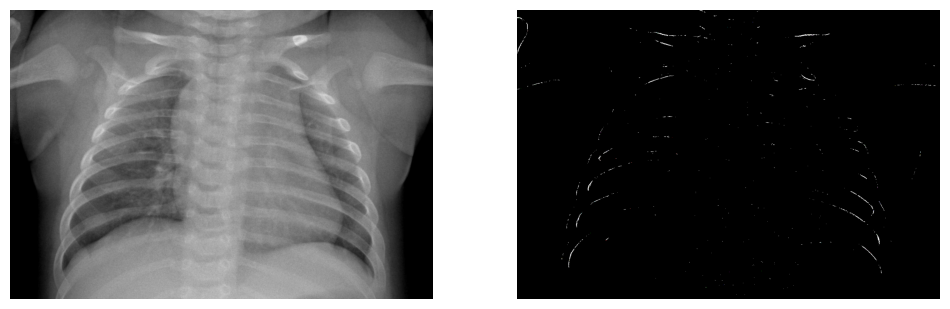

In [95]:
# Valoarea de prag setată pentru pasul 6
thresh = 100

# Imaginea pe care o vom procesa
img_path = images[0]
image = cv2.imread(img_path)


# TODO 1: Conversie în grayscale pentru procesare mai rapidă și eficientă
gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# TODO 2: Aplicarea CLAHE pentru îmbunătățirea contrastului
img_clahe = clahe(gray_img)

#plot_images(1, 1, [img_clahe])

# TODO 3: Aplicarea filtrului Sobel pentru detectarea marginilor
sobelx = cv2.Sobel(img_clahe, cv2.CV_64F, 1, 0, ksize=3)  # Margini orizontale
sobely = cv2.Sobel(img_clahe, cv2.CV_64F, 0, 1, ksize=3)  # Margini verticale

# TODO 4: Calcularea magnitudinii marginilor pentru a combina rezultatele (Hint: cv2.magnitude)
edges = cv2.magnitude(sobelx, sobely)

# TODO 5: Normalizarea imaginii pentru a avea valori între 0 și 255
edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# TODO 6: Aplicarea threshold-ului pentru a păstra doar marginile importante
_, rib_mask = cv2.threshold(edges, thresh, 255, cv2.THRESH_BINARY)

# TODO 9: Afișarea imaginii originale și a imaginii cu scheletul evidențiat
plot_images(2, 1, [image, rib_mask])